In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [526]:
%run 'functions.py'

In [499]:
total_usage_2012 = pd.read_parquet('../data/total_usage_2012.gzip')
total_usage_2013 = pd.read_parquet('../data/total_usage_2013.gzip')
total_usage_2014 = pd.read_parquet('../data/total_usage_2014.gzip')

In [4]:
total_usage_2013_1 = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() <= '2013-02-27') & (~total_usage_2013['treated'])]
total_usage_2014 = total_usage_2014.loc[(total_usage_2014['date_time'].dt.normalize() <= '2014-02-27') & (~total_usage_2014['treated'])]

In [545]:
total_usage_2012 = total_usage_2012.loc[(total_usage_2012['date_time'].dt.normalize() >= '2012-07-01') & (~total_usage_2012['treated'])]
total_usage_2013_2 = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() >= '2013-07-01') & (~total_usage_2013['treated'])]

In [56]:
total_acorn = pd.read_parquet('../data/total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [547]:
# clean the data, remove houses that have more than x% of their hh data missing
def clean_house(df, x):
    missing = df.loc[df.isna().sum(axis=1) / df.shape[1] > x, :].index
    return df.drop(index=missing)

In [9]:
# clean the data, remove timestamps that have more than x% of their house data missing
def clean_time(df, x):
    missing = df.loc[:, df.isna().sum(axis=0) / df.shape[0] > x].columns
    return df.drop(columns=missing)

what this shows is that after only cleaning the house level data there are time level data that have more than 1% missing
but that the missing fraction isn't that high altogether. so, it's okay.

In [10]:
# percent = a_2013_clean.isna().sum(axis=0) / len(a_2013_clean)
# percent[percent > 0.01]

In [549]:
def house_intersect(a1, a2):

    control_houses = set(a1.index).intersection(set(a2.index))
    
    a1 = a1.loc[a1.index.isin(control_houses)]
    a2 = a2.loc[a2.index.isin(control_houses)]
    
    return a1, a2

In [509]:
def control_get_matrices(c1, c2, x):
    
    a1 = c1.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    a2 = c2.pivot_table(index='house_id', columns='date_time', values='KWH/hh')
    
    print(a1.shape, a2.shape)
    
    a1 = clean_house(a1, x)
    a2 = clean_house(a2, x)
    
    print('after cleaning', a1.shape, a2.shape)
    
    a1, a2 = house_intersect(a1, a2)
    
    print('after intersection', a1.shape, a2.shape)
    
    print('percentage of nans:', frac_nans(a1), frac_nans(a2))
    
    return a1, a2

In [14]:
def frac_nans(mat):
    return round(mat.isna().sum().sum() / (mat.shape[0] * mat.shape[1])*100, 3)

In [550]:
a_2012_, a_2013_2 = control_get_matrices(total_usage_2012, total_usage_2013_2, 0)

(4428, 5856) (4253, 8832)
after cleaning (2031, 5856) (1665, 8832)
after intersection (802, 5856) (802, 8832)
percentage of nans: 0.0 0.0


In [15]:
a_2013_, a_2014_ = control_get_matrices(total_usage_2013_1, total_usage_2014, 0)

(4406, 2784) (4065, 2784)
after cleaning (2000, 2784) (2000, 2784)
percentage of nans: 0.0 0.0


In [23]:
# divide along columns by default
# train_size between 0-1
def test_train_split(df, train_size, axis=1):
    all_columns = set(df.columns)
    train = set(random.sample(all_columns, math.floor(train_size * len(all_columns))))
    test = all_columns - train
    return df.loc[:, df.columns.isin(train)], df.loc[:, df.columns.isin(test)]

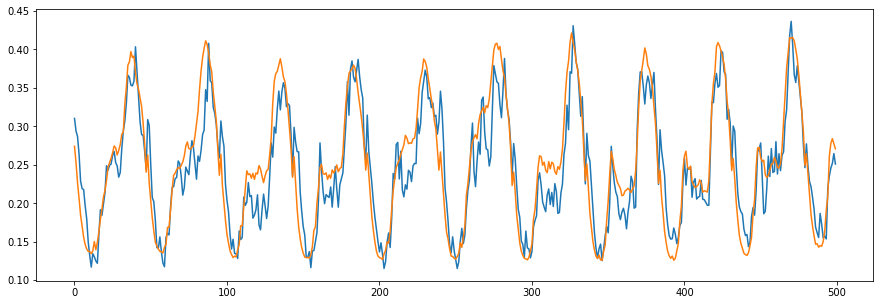

In [87]:
t=500
plt.figure(figsize=(15, 5))
plt.plot(np.nanmean(test, axis=0)[:t])
plt.plot(np.nanmean(train, axis=0)[:t]);

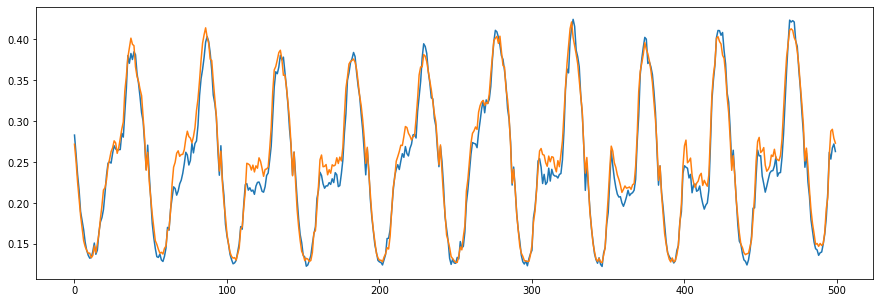

In [89]:
t=500
plt.figure(figsize=(15, 5))
plt.plot(np.nanmean(test, axis=0)[:t])
plt.plot(np.nanmean(train, axis=0)[:t]);

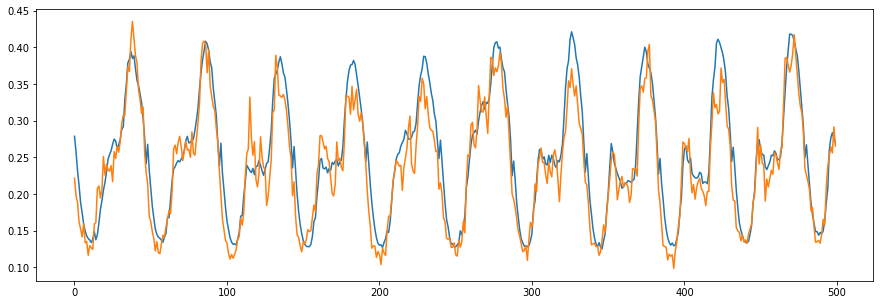

In [109]:
t=500
plt.figure(figsize=(15, 5))
plt.plot(np.nanmean(test, axis=0)[:t])
plt.plot(np.nanmean(train, axis=0)[:t]);

In [259]:
def find_error(df1, df2, t):
    
    train1_, test1_ = train_test_split(df1, train_size=t, random_state=220)
    train2_, test2_ = train_test_split(df2, train_size=t, random_state=220)
    
    n=0
    train1 = impute(train1_.iloc[n:, :].values, np.nanmedian, 1)
    test1 = impute(test1_.iloc[n:, :].values, np.nanmedian, 1)
    train2 = impute(train2_.iloc[n:, :].values, np.nanmedian, 1)
    test2 = impute(test2_.iloc[n:, :].values, np.nanmedian, 1)
    
    train1_inv = np.linalg.pinv(train1)
    X = train1_inv @ train2
    test2_est = test1 @ X
    
    test2_est_ = pd.DataFrame(test2_est, columns=test2_.columns, index=test2_.index)
    
#     return math.sqrt(mean_squared_error(test2.flatten(), test2_est.flatten()))
#     return rmspe(np.ma.masked_invalid(test2.flatten()), np.ma.masked_invalid(test2_est.flatten()))
#     return rmspe(np.ma.masked_invalid(test2.mean(axis=0)), np.ma.masked_invalid(test2_est.mean(axis=0)))
    return test2_, test2_est_

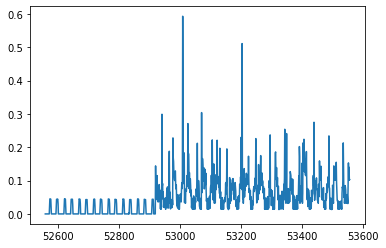

In [26]:
plt.plot(total_usage_2013.loc[total_usage_2013['house_id'] == 'MAC000006']['KWH/hh'][:1000])

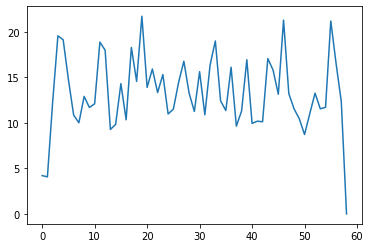

In [71]:
daily=[]
for n in range(1, 60):
    daily.append(a_2013_sliced_.iloc[99][48*(n-1):48*n].sum())
plt.plot(daily)

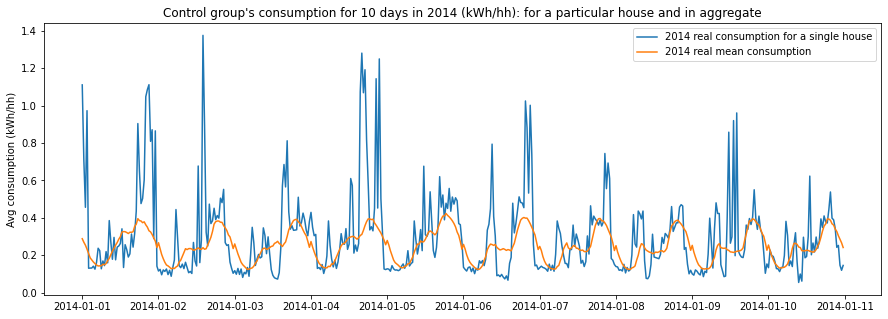

In [42]:
plt.figure(figsize=(15, 5))
n=10
house=5
plt.plot(a_2014_.iloc[house][:48*n], label='2014 real consumption for a single house')
# plt.plot(a_2013_sliced_.iloc[house][:48*n].values, label='2013 single house')
plt.plot(a_2014_.mean(axis=0)[:48*n], label='2014 real mean consumption')
# plt.plot(a_2013_sliced_.mean(axis=0)[:48*n].values, label='2013 avg')
plt.ylabel('Avg consumption (kWh/hh)')
plt.title('Control group\'s consumption for 10 days in 2014 (kWh/hh): for a particular house and in aggregate')
plt.savefig('../figs/2014_control_real_AVG_PERHOUSE.png')
plt.legend(loc=1)
plt.show()

# now let's try a constrained optimization #

In [166]:
import cvxpy as cp

train1_, test1_ = train_test_split(a_2013_sliced_, train_size=0.7, random_state=220)
train2_, test2_ = train_test_split(a_2014_, train_size=0.7, random_state=220)

A = train1_.iloc[:20, :200].values
X = cp.Variable((200, 200))
B = train2_.iloc[:20, :200].values
objective = cp.Minimize(cp.abs(A @ X - B))
constraints = [(test1_.iloc[:20, :200].values @ X) >= 0]
problem = cp.Problem(objective, constraints)

problem.solve()

ValueError: The 'minimize' objective must resolve to a scalar.

In [77]:
outcome = test1_.iloc[:200, :200].values @ X.value

In [78]:
outcome_ = pd.DataFrame(outcome, index=test2_.iloc[:200, :200].index, columns=test2_.iloc[:200, :200].columns)

In [105]:
print('the MSE between the optimized estimation and the actual value for the test set in 2014:', round(mean_squared_error(outcome, test2_.iloc[:200, :200]), 3))

the MSE between the optimized estimation and the actual value for the test set in 2014: 0.399


In [106]:
print('the MSE between the optimized estimation and the actual value for the test set in 2014, mean over all houses:', round(mean_squared_error(outcome_.mean(axis=0), test2_.iloc[:200, :200].mean(axis=0)), 3))

the MSE between the optimized estimation and the actual value for the test set in 2014, mean over all houses: 0.022


In [112]:
print('the MSE between the optimized estimation and the actual value for the test set in 2014, mean over all time indices:', round(mean_squared_error(outcome_.mean(axis=1), test2_.iloc[:200, :200].mean(axis=1)), 3))

the MSE between the optimized estimation and the actual value for the test set in 2014, mean over all time indices: 0.14


In [108]:
print('the MSE between the estimation and the actual value for the test set in 2014:', round(mean_squared_error(test_est.iloc[:200, :200], test2_.iloc[:200, :200]), 3))

the MSE between the estimation and the actual value for the test set in 2014: 0.169


In [109]:
print('the MSE between the estimation and the actual value for the test set in 2014, mean over all houses:', round(mean_squared_error(test_est.iloc[:200, :200].mean(axis=0), test2_.iloc[:200, :200].mean(axis=0)), 3))

the MSE between the estimation and the actual value for the test set in 2014, mean over all houses: 0.001


In [111]:
print('the MSE between the estimation and the actual value for the test set in 2014, mean over all time indices:', round(mean_squared_error(test_est.iloc[:200, :200].mean(axis=1), test2_.iloc[:200, :200].mean(axis=1)), 3))

the MSE between the estimation and the actual value for the test set in 2014, mean over all time indices: 0.032


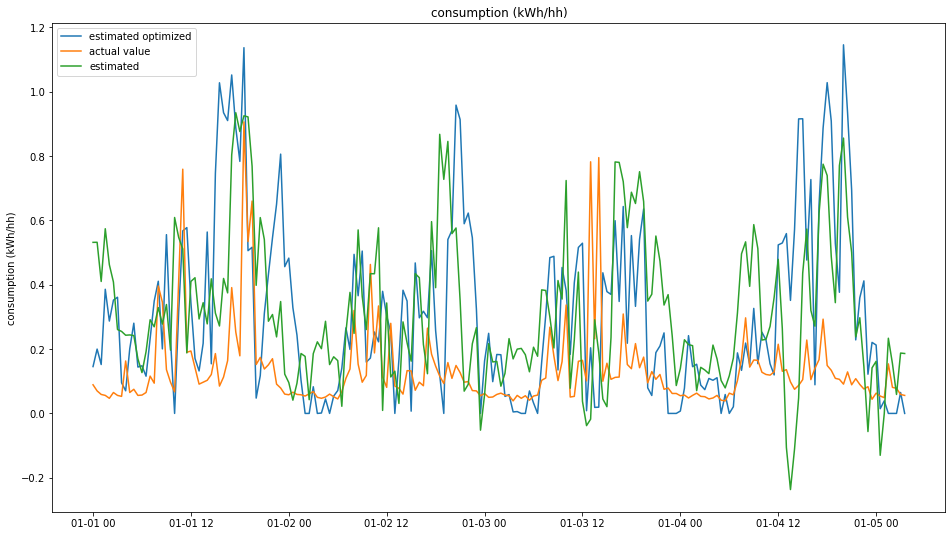

In [96]:
plt.figure(figsize=(16, 9))
house=5
plt.plot(outcome_.iloc[house], label='estimated optimized')
plt.plot(test2_.iloc[house, :200], label='actual value')
plt.plot(test_est.iloc[house, :200], label='estimated')
plt.ylabel('consumption (kWh/hh)')
plt.title('consumption (kWh/hh)')
plt.legend()
plt.show()

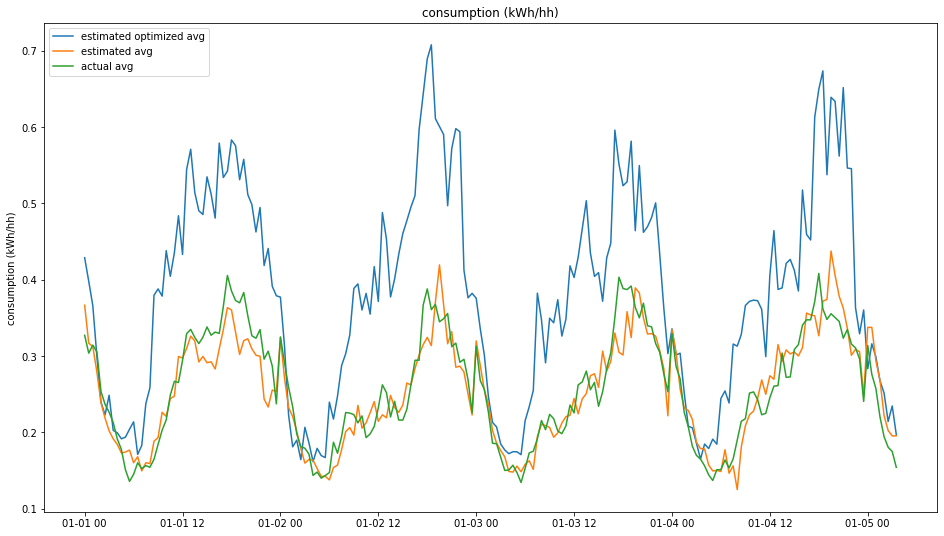

In [97]:
plt.figure(figsize=(16, 9))
plt.plot(outcome_.mean(axis=0), label='estimated optimized avg')
plt.plot(test_est.iloc[:200, :200].mean(axis=0), label='estimated avg')
plt.plot(test2_.iloc[:200, :200].mean(axis=0), label='actual avg')
plt.ylabel('consumption (kWh/hh)')
plt.title('consumption (kWh/hh)')
plt.legend()
plt.show()

In [140]:
daily_house_2013 = df_2013_control.groupby([df_2013_control['date_time'].dt.normalize(), df_2013_control['house_id']]).sum()

In [141]:
daily_house_2013 = daily_house_2013.unstack()

In [144]:
daily_mean = daily_house_2013.mean(axis=1)

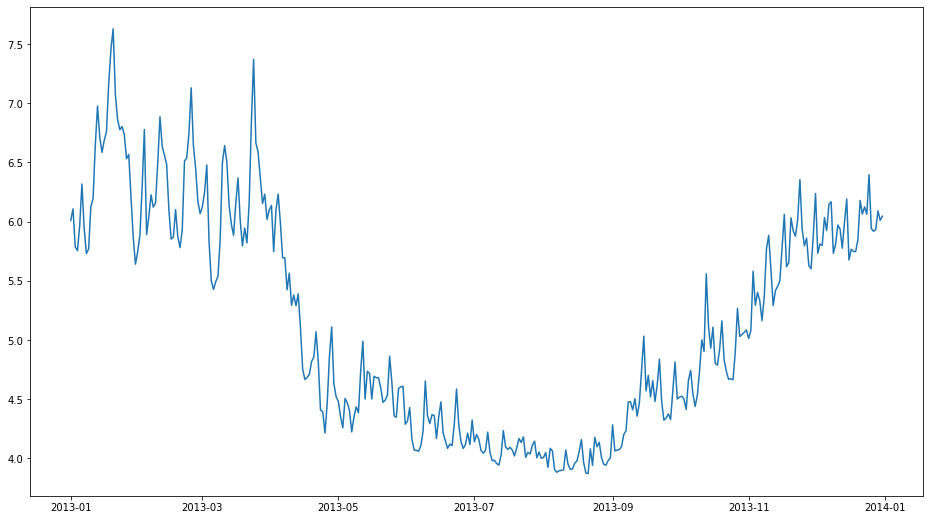

In [142]:
plt.figure(figsize=(16, 9))
plt.plot(daily_house_2013.mean(axis=1));

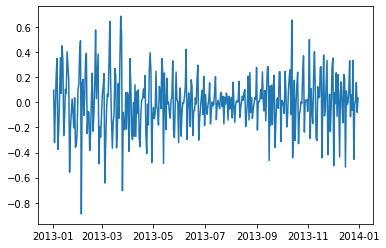

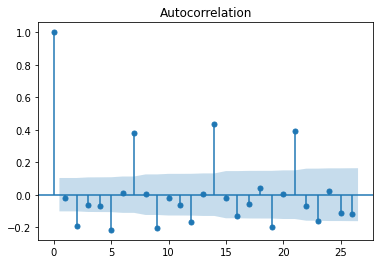

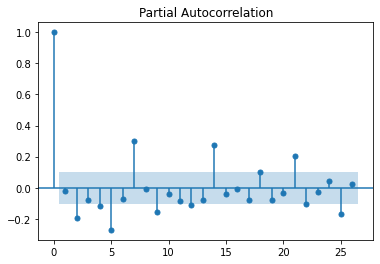

In [156]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.plot(daily_mean.diff())

# d = 1
plot_acf(daily_mean.diff().dropna());

# p = 1
plot_pacf(daily_mean.diff().dropna());

In [157]:
from statsmodels.tsa.arima.model import ARIMA

# (p, d, q=1 confused a lil but ACF, it's okay)
model = ARIMA(daily_mean, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  36.724
Date:                Thu, 07 Apr 2022   AIC                            -67.448
Time:                        13:19:49   BIC                            -55.756
Sample:                    01-01-2013   HQIC                           -62.801
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6861      0.070      9.781      0.000       0.549       0.824
ma.L1         -0.8565      0.055    -15.476      0.000      -0.965      -0.748
sigma2         0.0478      0.003     15.918      0.0

/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [162]:
train = daily_mean[:255]
test = daily_mean[255:]

/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To si

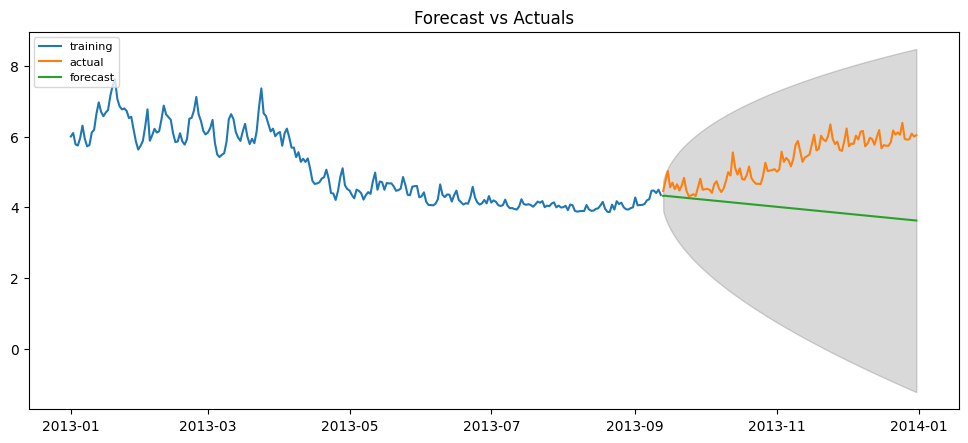

In [164]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(110, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [69]:
print('mean error, taking the mean before taking the difference')
np.nanmean(np.nanmean(test, axis=0) - np.nanmean(test_est, axis=0))

mean error, taking the mean before taking the difference


-0.0017424131118834135

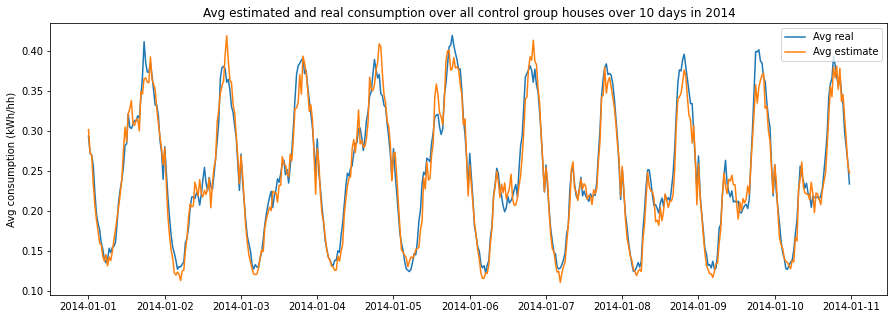

In [38]:
plt.figure(figsize=(15, 5))
# number of days
n=10
house=28
plt.plot(test.mean(axis=0)[:48*n], label='Avg real')
plt.plot(test_est.mean(axis=0)[:48*n], label='Avg estimate')
# plt.plot(test.iloc[house][:48*n], label='actual value')
# plt.plot(test_est.iloc[house][:48*n], label='estimate')
plt.ylabel('Avg consumption (kWh/hh)')
plt.title('Avg estimated and real consumption over all control group houses over 10 days in 2014')
plt.savefig('../figs/2014_control_pred_real_AVG.png')
plt.legend()
plt.show()

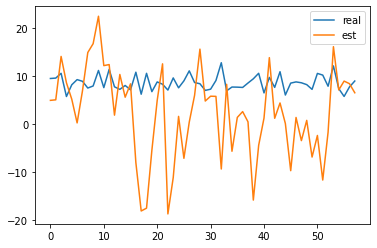

In [130]:
real_daily=[]
est_daily=[]
house=89
for n in range(1, 59):
    real_daily.append(test.iloc[house][48*(n-1):48*n].sum())
    est_daily.append(test_est.iloc[house][48*(n-1):48*n].sum())
plt.plot(real_daily, label='real')
plt.plot(est_daily, label='est')
plt.legend()
plt.show()

In [207]:
rmspe(test.mean(axis=0), test_est.mean(axis=0))

12.926445030646352

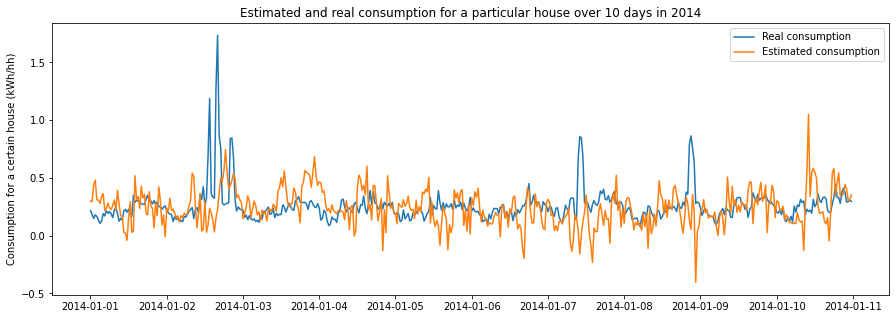

In [39]:
plt.figure(figsize=(15, 5))
# number of days
n=10

plt.plot(test.iloc[0][:48*n], label='Real consumption')
plt.plot(test_est.iloc[0][:48*n], label='Estimated consumption')
plt.ylabel('Consumption for a certain house (kWh/hh)')
plt.title('Estimated and real consumption for a particular house over 10 days in 2014')
plt.legend()
plt.savefig('../figs/2014_control_pred_real_PERHOUSE.png')
plt.show()

In [71]:
print('mean percent error, taking the difference before taking the mean')
np.nanmean(np.nanmean((test - test_est)/test, axis=0))

mean percent error, taking the difference before taking the mean


nan

In [73]:
print('mean error, taking the mean before taking the difference')
np.nanmean((np.nanmean(test, axis=0) - np.nanmean(test_est, axis=0))/np.nanmean(test, axis=0)*100)

mean error, taking the mean before taking the difference


-0.814861307104179

In [68]:
print('mean error, taking the difference before taking the mean')
np.nanmean(np.nanmean(test - test_est, axis=0))

mean error, taking the difference before taking the mean


-0.0017424131118834248

In [69]:
print('mean error, taking the mean before taking the difference')
np.nanmean(np.nanmean(test, axis=0) - np.nanmean(test_est, axis=0))

mean error, taking the mean before taking the difference


-0.0017424131118834135

In [292]:
48*15

720

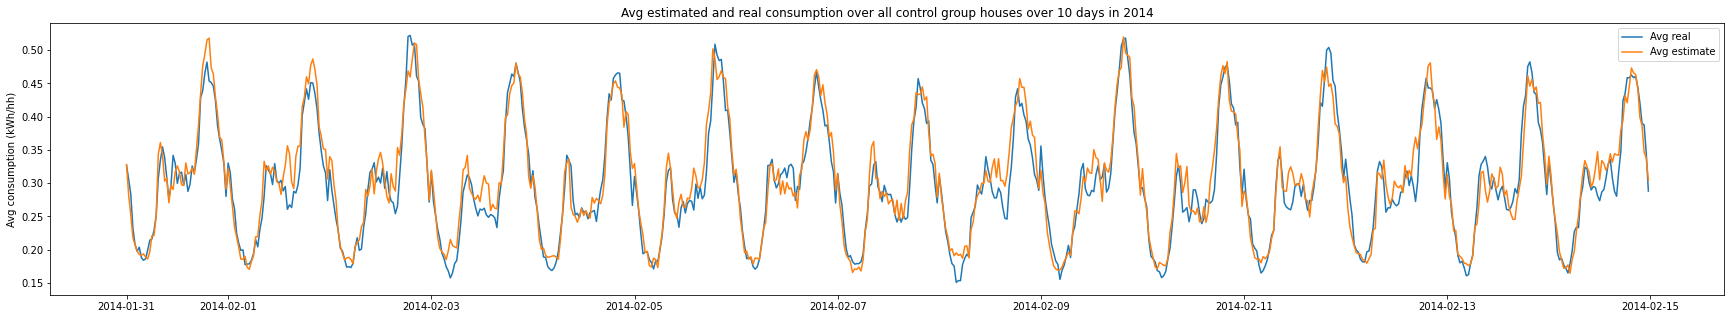

In [298]:
plt.figure(figsize=(30, 5))
start=720*2
end=720*3
plt.plot(t_affluent.mean(axis=0)[start:end], label='Avg real')
plt.plot(t_est_affluent.mean(axis=0)[start:end], label='Avg estimate')
plt.ylabel('Avg consumption (kWh/hh)')
plt.title('Avg estimated and real consumption over all control group houses over 10 days in 2014')
# plt.savefig('../figs/2014_control_pred_real_AVG.png')
plt.legend()
plt.show()

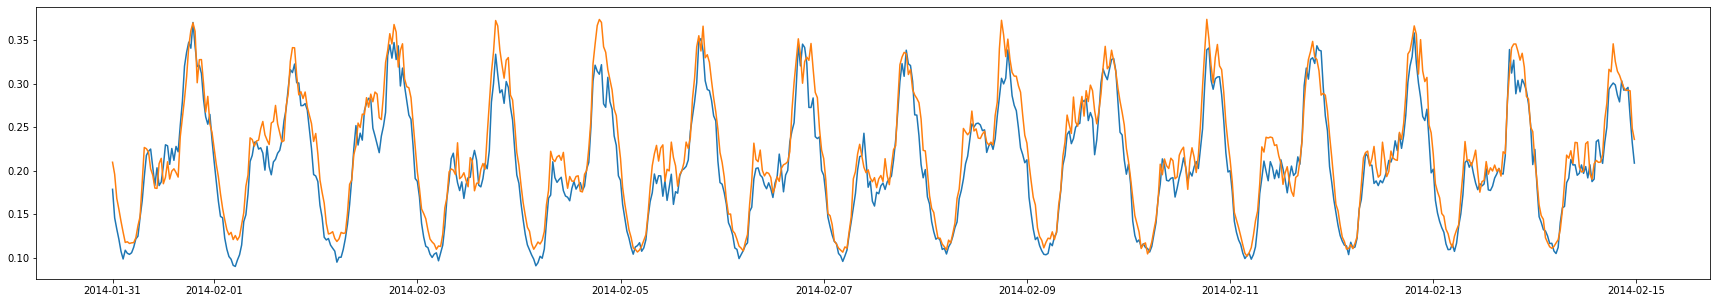

In [299]:
plt.figure(figsize=(30, 5))
# number of days
start=720*2
end=720*3
plt.plot(t_adversity.mean(axis=0)[start:end], label='Avg real')
plt.plot(t_est_adversity.mean(axis=0)[start:end], label='Avg estimate');

In [ ]:
a_2013_aff = get_dem_mat(a_2013_, affluent)
a_2013_com = get_dem_mat(a_2013_, comfortable)
a_2013_adv = get_dem_mat(a_2013_, adversity)

a_2014_aff = get_dem_mat(a_2014_, affluent)
a_2014_com = get_dem_mat(a_2014_, comfortable)
a_2014_adv = get_dem_mat(a_2014_, adversity)

In [465]:
def split_into_10(df, n, s):
    from math import floor
    bar = pd.DataFrame()
    for i in range(floor(df.shape[0]/n)):
        bar = pd.concat([bar, df.iloc[n*i:n*(i+1), :].mean(axis=0)], axis=1)
    bar.columns = np.repeat(s, bar.shape[1])
    return bar.T

In [466]:
n=50
a_2013_aff_bar = split_into_10(a_2013_aff, n, 'aff')
a_2013_com_bar = split_into_10(a_2013_com, n, 'com')
a_2013_adv_bar = split_into_10(a_2013_adv, n, 'adv')

a_2014_aff_bar = split_into_10(a_2014_aff, n, 'aff')
a_2014_com_bar = split_into_10(a_2014_com, n, 'com')
a_2014_adv_bar = split_into_10(a_2014_adv, n, 'adv')

In [468]:
a_2013_bar = pd.concat([a_2013_aff_bar, a_2013_com_bar, a_2013_adv_bar])
a_2014_bar = pd.concat([a_2014_aff_bar, a_2014_com_bar, a_2014_adv_bar])

In [445]:
def get_bar_subset(df, s):
    return df.loc[df.index==s]

<AxesSubplot:>

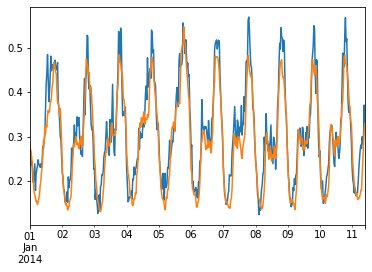

In [494]:
t_bar.iloc[1,:500].plot()
t_est_bar.iloc[1,:500].plot()

In [485]:
train_sizes = np.arange(0.3, 0.75, 0.05)

mpe_bar=[]
mpe_bar_aff=[]
mpe_bar_com=[]
mpe_bar_adv=[]

for t_size in train_sizes:
    t_bar, t_est_bar = find_error(a_2013_bar, a_2014_bar, t_size)
    t_bar_aff, t_est_bar_aff = find_error(a_2013_aff_bar, a_2014_aff_bar, t_size)
    t_bar_com, t_est_bar_com = find_error(a_2013_com_bar, a_2014_com_bar, t_size)
    t_bar_adv, t_est_bar_adv = find_error(a_2013_adv_bar, a_2014_adv_bar, t_size)
    
#     t_bar_aff = get_bar_subset(t_bar, 'aff')
#     t_est_bar_aff = get_bar_subset(t_est_bar, 'aff')

#     t_bar_com = get_bar_subset(t_bar, 'com')
#     t_est_bar_com = get_bar_subset(t_est_bar, 'com')

#     t_bar_adv = get_bar_subset(t_bar, 'adv')
#     t_est_bar_adv = get_bar_subset(t_est_bar, 'adv')

    mpe_bar.append(get_mpe(t_bar, t_est_bar))
    mpe_bar_aff.append(get_mpe(t_bar_aff, t_est_bar_aff))
    mpe_bar_com.append(get_mpe(t_bar_com, t_est_bar_com))
    mpe_bar_adv.append(get_mpe(t_bar_adv, t_est_bar_adv))

In [472]:
# one mapping and segmented after
print(
mpe_bar[-1],
mpe_bar_aff[-1], 
mpe_bar_com[-1],
mpe_bar_adv[-1])

0.30171639954122326 0.4888598445809658 2.7060391166917963 0.9679659969784639


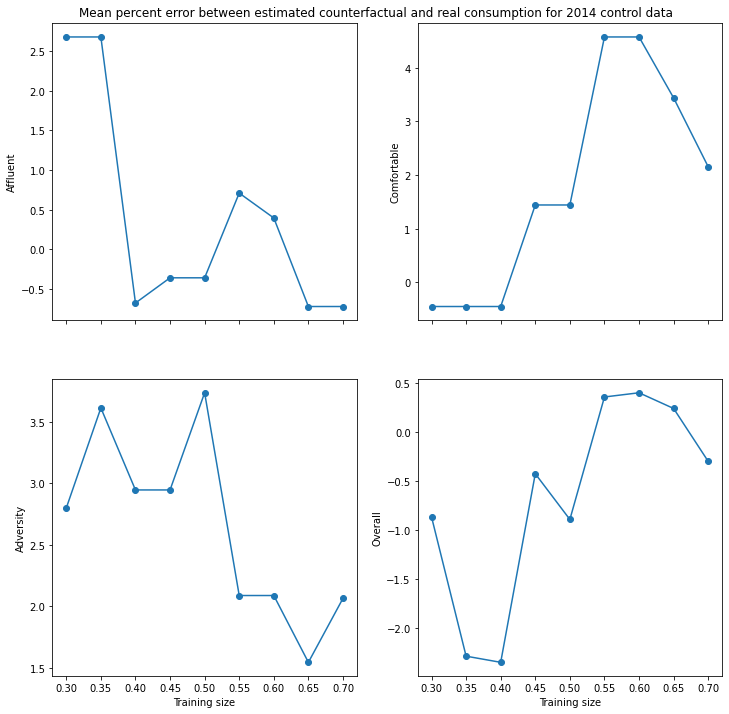

In [558]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(12, 12))
fig.suptitle('Mean percent error between estimated counterfactual and real consumption for 2014 control data', x=0.5, y=0.9)

ax[0, 0].plot(train_sizes, mpe_bar_aff, '-o')
ax[0, 0].set_ylabel('Affluent')

ax[0, 1].plot(train_sizes, mpe_bar_com, '-o')
ax[0, 1].set_ylabel('Comfortable')

ax[1, 0].plot(train_sizes, mpe_bar_adv, '-o')
ax[1, 0].set_ylabel('Adversity')
ax[1, 0].set_xlabel('Training size')

ax[1, 1].plot(train_sizes, mpe_bar, '-o')
ax[1, 1].set_ylabel('Overall')
ax[1, 1].set_xlabel('Training size')

plt.savefig('../figs/error_agg_multi_reg_14');

## the same analysis but on the 2012/2013 data ##

In [537]:
def get_dem_mat_new_idkwhatsgoingon(mat, dem):
    return  mat.iloc[mat.index.isin(dem), :]

In [541]:
a_2013_aff_2 = get_dem_mat_new_idkwhatsgoingon(a_2013_2, affluent)
a_2013_com_2 = get_dem_mat_new_idkwhatsgoingon(a_2013_2, comfortable)
a_2013_adv_2 = get_dem_mat_new_idkwhatsgoingon(a_2013_2, adversity)

a_2012_aff_2 = get_dem_mat_new_idkwhatsgoingon(a_2012_, affluent)
a_2012_com_2 = get_dem_mat_new_idkwhatsgoingon(a_2012_, comfortable)
a_2012_adv_2 = get_dem_mat_new_idkwhatsgoingon(a_2012_, adversity)

In [542]:
train_sizes = np.arange(0.3, 0.75, 0.05)

mpe=[]
socio_mpe_aff=[]
socio_mpe_com=[]
socio_mpe_adv=[]

for t_size in train_sizes:
    t, t_est = find_error(a_2012_, a_2013_2, t_size)
    t_affluent, t_est_affluent = find_error(a_2012_aff_2, a_2013_aff_2, t_size)
    t_comfortable, t_est_comfortable = find_error(a_2012_com_2, a_2013_com_2, t_size)
    t_adversity, t_est_adversity = find_error(a_2012_adv_2, a_2013_adv_2, t_size)

    mpe.append(get_mpe(t, t_est))
    socio_mpe_aff.append(get_mpe(t_affluent, t_est_affluent))
    socio_mpe_com.append(get_mpe(t_comfortable, t_est_comfortable))
    socio_mpe_adv.append(get_mpe(t_adversity, t_est_adversity))

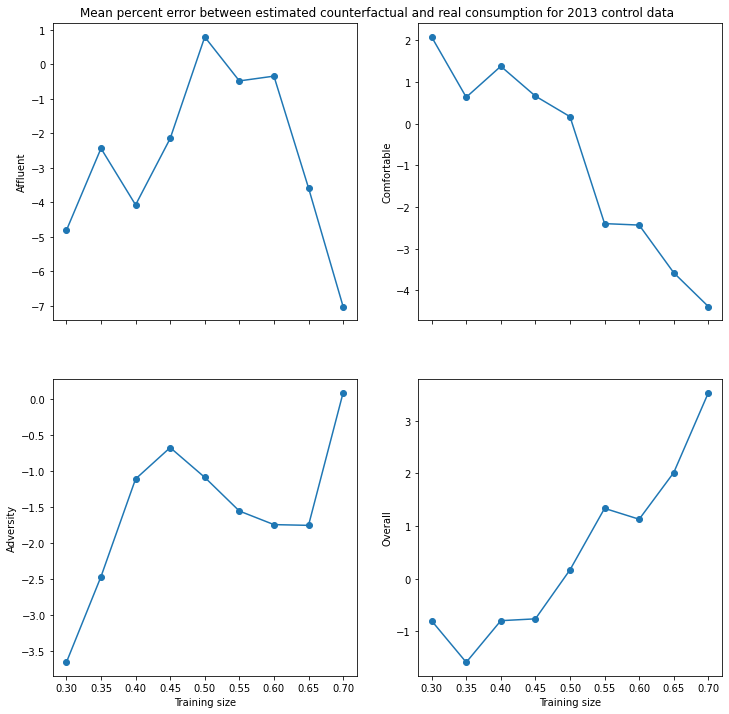

In [557]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(12, 12))
fig.suptitle('Mean percent error between estimated counterfactual and real consumption for 2013 control data', x=0.5, y=0.9)

ax[0, 0].plot(train_sizes, socio_mpe_aff, '-o')
ax[0, 0].set_ylabel('Affluent')

ax[0, 1].plot(train_sizes, socio_mpe_com, '-o')
ax[0, 1].set_ylabel('Comfortable')

ax[1, 0].plot(train_sizes, socio_mpe_adv, '-o')
ax[1, 0].set_ylabel('Adversity')
ax[1, 0].set_xlabel('Training size')

ax[1, 1].plot(train_sizes, mpe, '-o')
ax[1, 1].set_ylabel('Overall')
ax[1, 1].set_xlabel('Training size');

plt.savefig('../figs/error_multi_reg_13.png');

In [561]:
train_sizes = np.arange(0.3, 0.75, 0.05)

mpe=[]
socio_mpe_aff=[]
socio_mpe_com=[]
socio_mpe_adv=[]

for t_size in train_sizes:
    t, t_est = find_error(a_2013_, a_2014_, t_size)
    t_affluent, t_est_affluent = find_error(a_2013_aff, a_2014_aff, t_size)
    t_comfortable, t_est_comfortable = find_error(a_2013_com, a_2014_com, t_size)
    t_adversity, t_est_adversity = find_error(a_2013_adv, a_2014_adv, t_size)

    mpe.append(get_mpe(t, t_est))
    socio_mpe_aff.append(get_mpe(t_affluent, t_est_affluent))
    socio_mpe_com.append(get_mpe(t_comfortable, t_est_comfortable))
    socio_mpe_adv.append(get_mpe(t_adversity, t_est_adversity))

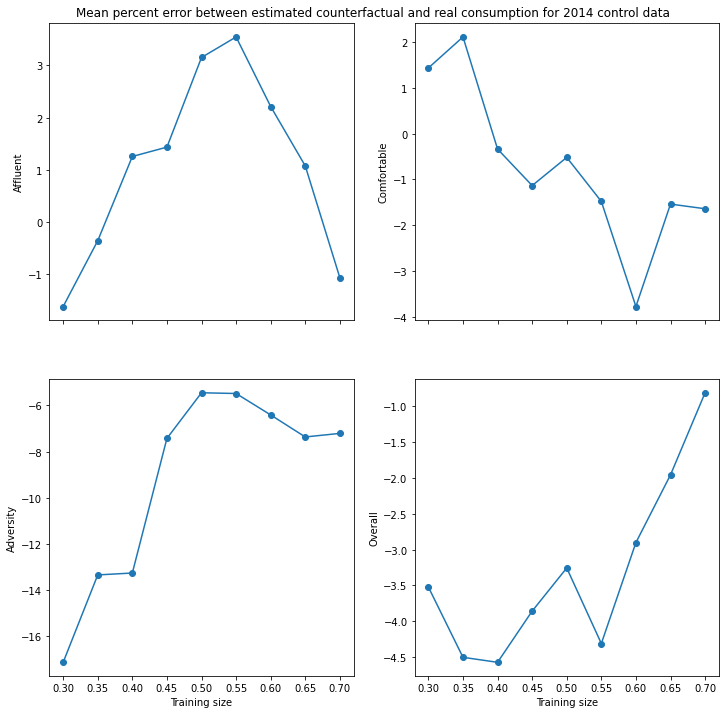

In [562]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(12, 12))
fig.suptitle('Mean percent error between estimated counterfactual and real consumption for 2014 control data', x=0.5, y=0.90)

ax[0, 0].plot(train_sizes, socio_mpe_aff, '-o')
ax[0, 0].set_ylabel('Affluent')

ax[0, 1].plot(train_sizes, socio_mpe_com, '-o')
ax[0, 1].set_ylabel('Comfortable')

ax[1, 0].plot(train_sizes, socio_mpe_adv, '-o')
ax[1, 0].set_ylabel('Adversity')
ax[1, 0].set_xlabel('Training size')

ax[1, 1].plot(train_sizes, mpe, '-o')
ax[1, 1].set_ylabel('Overall')
ax[1, 1].set_xlabel('Training size');

plt.savefig('../figs/error_multi_reg_14.png');

In [226]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square((np.nanmean(t, axis=0) - np.nanmean(t_est, axis=0))/np.nanmean(t, axis=0))))*100

In [484]:
def get_mpe(t, t_est):
#     return np.absolute(np.nanmean((np.nanmean(t, axis=0) - np.nanmean(t_est, axis=0))/np.nanmean(t, axis=0))*100)
    return np.nanmean((np.nanmean(t, axis=0) - np.nanmean(t_est, axis=0))/np.nanmean(t, axis=0))*100

In [ ]:
# train_sizes = np.arange(0.3, 0.75, 0.05)

# mpe = []
# mpe_aff = []
# mpe_com = []
# mpe_adv = []

# for t_size in train_sizes:
    
#     mpe_aff.append(get_mpe(t_affluent, t_est_affluent))
#     mpe_com.append(get_mpe(t_comfortable, t_est_comfortable))
#     mpe_adv.append(get_mpe(t_adversity, t_est_adversity))

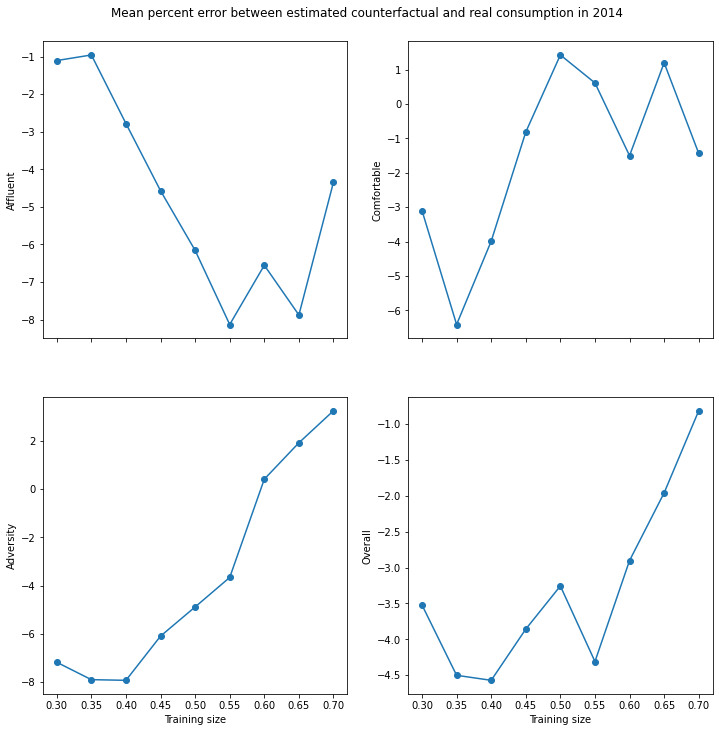

In [182]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(12, 12))
fig.suptitle('Mean percent error between estimated counterfactual and real consumption in 2014', x=0.5, y=0.92)
# fig.ylabel('Training size')

ax[0, 0].plot(train_sizes, mpe_aff, '-o')
ax[0, 0].set_ylabel('Affluent')

ax[0, 1].plot(train_sizes, mpe_com, '-o')
ax[0, 1].set_ylabel('Comfortable')

ax[1, 0].plot(train_sizes, mpe_adv, '-o')
ax[1, 0].set_ylabel('Adversity')
ax[1, 0].set_xlabel('Training size')

ax[1, 1].plot(train_sizes, mpe, '-o')
ax[1, 1].set_ylabel('Overall')
ax[1, 1].set_xlabel('Training size');

plt.savefig('../figs/error_analysis_multireg_overall.png');

In [121]:
np.max(mpe_1)

-0.8148613071041789

In [122]:
np.nanmean(mpe_1)

-3.3004261017143506

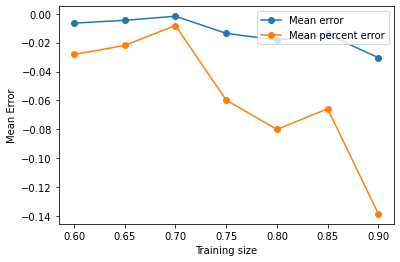

In [107]:
plt.plot(train_sizes, me_1, '-o', label='Mean error')
# plt.plot(train_sizes, me_2, '-o', label='me_2')
plt.plot(train_sizes, mpe_1, '-o', label='Mean percent error')
# plt.plot(train_sizes, mpe_2, '-o', label='mpe_2')
plt.legend(loc=1)
plt.ylabel('Mean Error')
plt.xlabel('Training size');

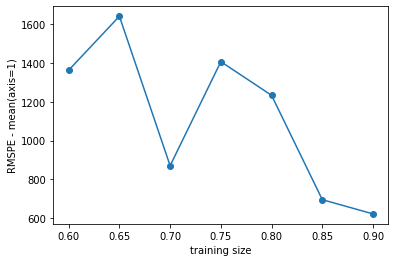

In [133]:
plt.plot(train_sizes, mpe_1, '-o')
plt.ylabel('mpe_1')
plt.xlabel('training size');

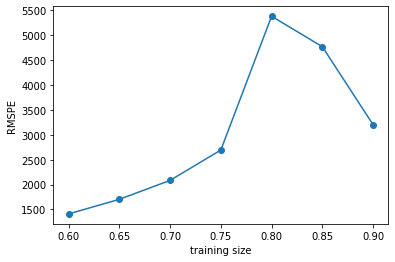

In [129]:
plt.plot(train_sizes, MSE, '-o')
plt.ylabel('RMSPE')
plt.xlabel('training size');

In [134]:
transform_KWH(0.6)

=  123.07692307692308 hours of TV
=  128.0 hours of fridge
=  112.94117647058823 hours of washing machine
=  10.32258064516129 hours of dryer
=  8.228571428571428 hours of AC


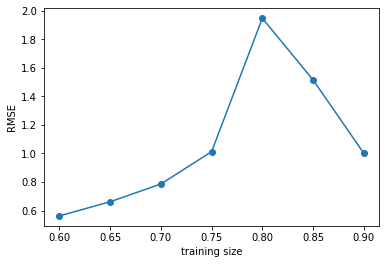

In [125]:
plt.plot(train_sizes, MSE, '-o')
plt.ylabel('RMSE')
plt.xlabel('training size');